<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/DataPreprocessing/SpectrogramPreprocessingASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert Music to Spectrograms

This notebook can be used to preprocess the free music archive dataset (FMA)
to chroma STFT, mel spectrograms and spectral contrast diagrams.

The notebook uses the small dataset currently due to execution time.

## 1 Imports

In [113]:
# import necessary librarys
import numpy as np
import math
import pandas as pd
import cv2
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import time
from tqdm import tqdm

import os
import re
from PIL import Image
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

# default setup for matplotlib figure params
plt.rcParams['figure.figsize'] = (10, 3)

In [114]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 Data Prep

In [115]:
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory


In [116]:
# download an unzip fma dataset
! kaggle datasets download -d imsparsh/fma-free-music-archive-small-medium
! unzip -n -q fma-free-music-archive-small-medium.zip -d data

fma-free-music-archive-small-medium.zip: Skipping, found more recently modified local copy (use --force to force download)


In [117]:
# define list with all genres; small dataset only has this 8 genres
genres_list = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'Pop', 'Rock', 'International']
len(genres_list)

8

## 3 Create Spectrogramm

### 3.1 General Setup

In [118]:
# set the default path to the data sources
default_dir = "/content/data/"

In [119]:
# Get Genres and Track IDs from the tracks.csv file
filename_metadata = default_dir + "fma_metadata/tracks.csv"
tracks = pd.read_csv(filename_metadata, header=2, low_memory=False)
tracks_array = tracks.values
all_files=[]
tracks_id_array = tracks_array[: , 0]
tracks_genre_array = tracks_array[: , 40]
tracks_id_array = tracks_id_array.reshape(tracks_id_array.shape[0], 1)
tracks_genre_array = tracks_genre_array.reshape(tracks_genre_array.shape[0], 1)

# use small dataset folder and get all sub directorys
#   (music of each genre is organized in a sub folder in this case)
folder_sample = default_dir + "fma_small/fma_small/"
directories = [d for d in os.listdir(folder_sample)
               if os.path.isdir(os.path.join(folder_sample, d))]

# get all music files (mp3-format) of the small dataset
if not os.path.exists('Train_Spectogram_Images'):
    os.makedirs('Train_Spectogram_Images')
for d in directories:
    label_directory = os.path.join(folder_sample, d)
    file_names = [os.path.join(label_directory, f)
                  for f in os.listdir(label_directory)
                  if f.endswith(".mp3")]
    all_files.extend(file_names)

In [120]:
# check the lenght of all files; should be 8000 with approx.
#   1000 files per class
len(all_files)

8000

In [121]:
# read the fma metadata track file in a pandas dataframe
tracks_all = pd.read_csv(filename_metadata, header=1, index_col=0, low_memory=False)
tracks_all = tracks_all.dropna(how="all")
# tracks_all["genre_top"].value_counts()

In [122]:
# put parent genre of the first genre in 'genres' to non-specified 'genre_top'
track_info_wo_genre = tracks_all.loc[pd.isnull(tracks_all).any(1)]
genres_df = pd.read_csv(default_dir + '/fma_metadata/genres.csv')
genre_names = []
for i in track_info_wo_genre.genres:
    j = eval(i)+[0]
    if j[0] != 0:
        top_level = genres_df[genres_df.genre_id==j[0]].top_level.values[0]
        parent_genre = genres_df[genres_df.genre_id==top_level]['title'].values[0]
    else:
        parent_genre = np.nan
    genre_names.append(parent_genre)
track_info_ = tracks_all.copy()
track_info_.loc[track_info_wo_genre.index, 'genre_top'] = genre_names

# track_info_.genre_top.value_counts()

In [123]:
# read the genre csv in dataframe
genres_df = pd.read_csv(default_dir + 'fma_metadata/genres.csv')

### 3.2 Exploration of different spectrograms and times with librosa

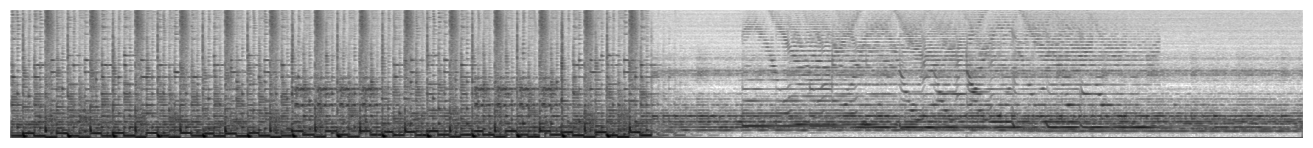

In [125]:
# plot mel spetrogramm of the first file (randomly chosen) in grayscale

test_file = all_files[0]
y, sr = librosa.load(test_file)
melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
mel = librosa.power_to_db(melspectrogram_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(mel,cmap='gray_r')

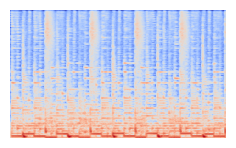

In [126]:
# plot mel spetrogramm with default colors for 5 seconds of music

test_file = all_files[0]
y, sr = librosa.load(test_file)
y = y[:len(y)//6]

# to possible param combinations possible for creating spectrogram:
#   - https://doi.org/10.1007/s13735-021-00206-5

# melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)

mel = librosa.power_to_db(melspectrogram_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(mel)

In [127]:
# get shape of the 5 second mel spectrogram image
melspectrogram_array.shape

(128, 216)

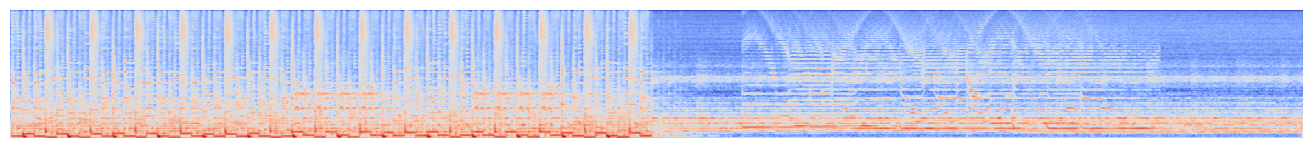

In [128]:
# plot mel spetrogramm with default colors for whole 30 seconds of music

test_file = all_files[0]
y, sr = librosa.load(test_file)
melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)

mel = librosa.power_to_db(melspectrogram_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(mel)

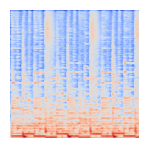

In [129]:
# plot mel spetrogramm with default colors for 3 seconds of music

mel_temp = mel[:, :mel.shape[1]//10]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel_temp.shape[1] / 100)
fig_size[1] = float(mel_temp.shape[0] / 100)
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(mel_temp)

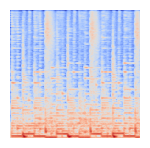

In [130]:
# plot mel spetrogramm with default colors for 3 seconds of music
#   comparison to version above: instead of cutting the spectrogram to 1/10
#   of the original length the audio time series is cutted to only get first three seconds

test_file = all_files[0]
y, sr = librosa.load(test_file)
y = y[:len(y)//10]
melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)

mel = librosa.power_to_db(melspectrogram_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(mel)

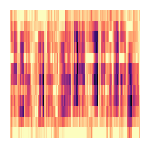

In [131]:
# plot mel chroma STFT with default colors for 5 seconds of music

y, sr = librosa.load(test_file)
y = y[:len(y)//6]
chroma_stft_array = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)

chroma = librosa.power_to_db(chroma_stft_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(chroma)

In [132]:
# get shape of the 5 second chroma STFT array
chroma_stft_array.shape

(12, 216)

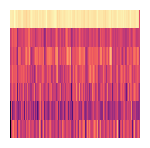

In [133]:
# plot spectral contrast with default colors for 5 seconds of music

y, sr = librosa.load(test_file)
y = y[:len(y)//6]
spectral_contrast_array = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)

spectral_contrast = librosa.power_to_db(spectral_contrast_array)
# Length and Width of Spectogram
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel.shape[1] / 100)
fig_size[1] = float(mel.shape[0] / 100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
librosa.display.specshow(spectral_contrast)

In [134]:
# get shape of the 5 second spectral contrast array
spectral_contrast_array.shape

(7, 216)

### 3.3 Functions for creation of different spectrograms

In [135]:
def create_melspectrogram(y: np.ndarray, sr: int, output_file: str, array_path: str = None):
    """
        Args:
            y : np.ndarray [shape=(..., n)] or None
                audio time-series. Multi-channel is supported.
            sr : number > 0 [scalar]
                sampling rate of ``y``
            output_file: str or pathlib.Path
                file to store the diagram
    """
    if not os.path.exists(os.path.dirname(output_file)):
      os.makedirs(os.path.dirname(output_file))
    # melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
    melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)

    mel = librosa.power_to_db(melspectrogram_array)
    # Length and Width of Spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(mel.shape[1] / 100)
    fig_size[1] = float(mel.shape[0] / 100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel)   # ,cmap='gray_r'
    plt.savefig(output_file, dpi=100)
    plt.close()
    if array_path is not None:
      np.save(array_path, melspectrogram_array)
    return melspectrogram_array

In [136]:
def create_chroma_stft(y: np.ndarray, sr: int, output_file: str, array_path: str = None):
    """
        Args:
            y : np.ndarray [shape=(..., n)] or None
                audio time-series. Multi-channel is supported.
            sr : number > 0 [scalar]
                sampling rate of ``y``
            output_file: str or pathlib.Path
                file to store the diagram
    """
    if not os.path.exists(os.path.dirname(output_file)):
      os.makedirs(os.path.dirname(output_file))
    chroma_stft_array = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)

    chroma = librosa.power_to_db(chroma_stft_array)
    # Length and Width of Spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(chroma_stft_array.shape[1] / 100)
    fig_size[1] = float(chroma_stft_array.shape[0] / 100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(chroma)
    plt.savefig(output_file, dpi=100)
    plt.close()
    if array_path is not None:
      np.save(array_path, chroma_stft_array)
    return chroma_stft_array

In [137]:
def create_spectral_contrast(y: np.ndarray, sr: int, output_file: str, array_path: str = None):
    """
        Args:
            y : np.ndarray [shape=(..., n)] or None
                audio time-series. Multi-channel is supported.
            sr : number > 0 [scalar]
                sampling rate of ``y``
            output_file: str or pathlib.Path
                file to store the diagram
    """
    if not os.path.exists(os.path.dirname(output_file)):
      os.makedirs(os.path.dirname(output_file))
    spectral_contrast_array = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)

    spectral_contrast = librosa.power_to_db(spectral_contrast_array)
    # Length and Width of Spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(spectral_contrast.shape[1] / 100)
    fig_size[1] = float(spectral_contrast.shape[0] / 100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(spectral_contrast)
    plt.savefig(output_file, dpi=100)
    plt.close()
    if array_path is not None:
      np.save(array_path, spectral_contrast_array)
    return spectral_contrast_array

In [138]:
# test the functions and explore the different shapes of the resulting arrays
y, sr = librosa.load(test_file)
y = y[:len(y)//6]

melspectrogram = create_melspectrogram(y, sr, "/content/test_melspectrogram.jpg")
chroma_stft = create_chroma_stft(y, sr, "/content/chroma_stft.jpg")
sepctral_contrast = create_spectral_contrast(y, sr, "/content/spectral_contrast.jpg")
melspectrogram.shape, chroma_stft.shape, spectral_contrast.shape

((128, 216), (12, 216), (7, 216))

### 3.4 Loop over dir to create spectorgram

In [139]:
# Iterate over all mp3 files and create spectorgrams for them
#   due to RAM memory limits in google colab, only 1/16 of the whole dataset can
#   be extracted at once; otherwise the loop will probably create "all RAM used"
#   exception; memory optimized like garbage collection have been tried out,
#   but haven't made any improvement

# create an array for all missing files
missing_files = []

# define the output directory of the images
output_dir = "All_Spectrogramms"
os.makedirs(output_dir, exist_ok=True)
start_time = time.time()

# define which part (1/16) of the data should be processed
i = 0

# iterate over 500 mp3 files and create spectrograms
for counter, f in enumerate(tqdm(all_files[i*500:(i+1)*500])):

    # proof, if file has mp3 extension
    match = re.search(folder_sample + r'.*/(.+?).mp3', f)
    if match is not None:
        # get necessary information out of the file
        track_id = int(match.group(1))
        track_index = list(tracks_id_array).index(track_id)
        genre = str(tracks_genre_array[track_index, 0])
        track_id = str(track_id)

        # try to load the mp3 data with librosa and create spectrograms
        try:
            y, sr = librosa.load(f)
            create_melspectrogram(y, sr, os.path.join(
                output_dir, "melspectrogram", genre, f"{track_id}_melspectrogram.jpg"),
                array_path=os.path.join(
                    output_dir, "melspectrogram", genre, f"{track_id}_melspectrogram.npy")
                )
            create_chroma_stft(y, sr, os.path.join(
                output_dir, "chroma_stft", genre, f"{track_id}_chroma_stft.jpg"),
                array_path=os.path.join(
                    output_dir, "chroma_stft", genre, f"{track_id}_chroma_stft.npy")
                )
            create_spectral_contrast(y, sr, os.path.join(
                output_dir, "spectral_contrast", genre, f"{track_id}_spectral_contrast.jpg"),
                array_path=os.path.join(
                    output_dir, "spectral_contrast", genre, f"{track_id}_spectral_contrast.npy")
                )

        # if file could not be loaded: append it to missing files and show exception
        except Exception as e:
          print(e)
          print(f)
          missing_files.append(f)
    else:
        print(f"Error: File {f} is not in .mp3 format")

# archive the files of the current extraction process and delete folder
shutil.make_archive(f"drive/MyDrive/{output_dir}/{output_dir}{i}", "zip", output_dir)
shutil.rmtree(output_dir)

# print the time, that the cell has taken to execute
print("Time taken: ", time.time()-start_time)

100%|██████████| 500/500 [09:59<00:00,  1.20s/it]


Time taken:  631.0132954120636


In [140]:
# show all missing files
missing_files

[]